# Adding new objects to Nengo

It is possible to add new objects
to the Nengo reference simulator.
This involves several steps and the creation
of several objects.
In this example, we'll go through these steps
in order to add a new neuron type to Nengo:
a rectified linear neuron.

The `RectifiedLinear` class is what you will use
in model scripts to denote that a particular ensemble
should be simulated using a rectified linear neuron
instead of one of the existing neuron types (e.g., `LIF`).

Normally, these kinds of frontend classes exist
in a file in the root `nengo` directory,
like `nengo/neurons.py` or `nengo/synapses.py`.
Look at these files for examples of how to make your own.
In this case, because we're making a neuron type,
we'll use `nengo.neurons.LIF` as an example
of how to make `RectifiedLinear`.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import nengo
from nengo.utils.ensemble import tuning_curves


# Neuron types must subclass `nengo.neurons.NeuronType`
class RectifiedLinear(nengo.neurons.NeuronType):
    """A rectified linear neuron model."""

    # We don't need any additional parameters here;
    # gain and bias are sufficient. But, if we wanted
    # more parameters, we could accept them by creating
    # an __init__ method.

    def gain_bias(self, max_rates, intercepts):
        """Return gain and bias given maximum firing rate and x-intercept."""
        gain = max_rates / (1 - intercepts)
        bias = -intercepts * gain
        return gain, bias

    def step(self, dt, J, output):
        """Compute rates in Hz for input current (incl. bias)"""
        output[...] = np.maximum(0., J)

You can use `RectifiedLinear` like any other neuron type
without making modifications to the reference simulator.
However, other objects, including more complicated neuron types,
may require changes to the reference simulator.

## Tuning curves

We can build a small network just to see the tuning curves.

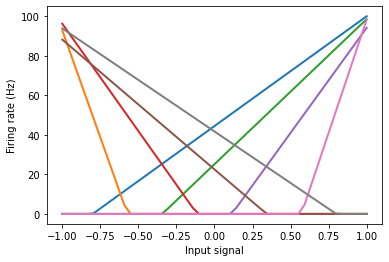

In [2]:
model = nengo.Network()
with model:
    encoders = np.tile([[1], [-1]], (4, 1))
    intercepts = np.linspace(-0.8, 0.8, 8)
    intercepts *= encoders[:, 0]
    A = nengo.Ensemble(
        8, dimensions=1,
        intercepts=intercepts,
        neuron_type=RectifiedLinear(),
        max_rates=nengo.dists.Uniform(80, 100),
        encoders=encoders)
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(A, sim)
plt.figure()
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)");

## 2D Representation example

Below is the same model as is made in the 2d_representation example,
except now using `RectifiedLinear` neurons insated of `nengo.LIF`.

In [3]:
model = nengo.Network(label='2D Representation', seed=10)
with model:
    neurons = nengo.Ensemble(100, dimensions=2, neuron_type=RectifiedLinear())
    sin = nengo.Node(output=np.sin)
    cos = nengo.Node(output=np.cos)
    nengo.Connection(sin, neurons[0])
    nengo.Connection(cos, neurons[1])
    sin_probe = nengo.Probe(sin, 'output')
    cos_probe = nengo.Probe(cos, 'output')
    neurons_probe = nengo.Probe(neurons, 'decoded_output', synapse=0.01)
with nengo.Simulator(model) as sim:
    sim.run(5)

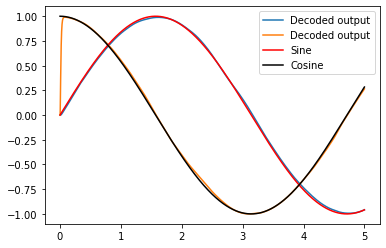

In [4]:
plt.figure()
plt.plot(sim.trange(), sim.data[neurons_probe], label="Decoded output")
plt.plot(sim.trange(), sim.data[sin_probe], 'r', label="Sine")
plt.plot(sim.trange(), sim.data[cos_probe], 'k', label="Cosine")
plt.legend();